## Описание Данных

- **Марка и модель автомобиля:** Категориальные данные, определяющие производителя и конкретную модель автомобиля (например, “Toyota Camry”, “BMW X5”).
- **Год выпуска:** Числовые данные, представляющие год производства автомобиля.
- **Пробег:** Числовые данные, указывающие общее расстояние, пройденное автомобилем (обычно в километрах или милях).
- **Тип кузова:** Категориальные данные, описывающие тип кузова автомобиля (например, “седан”, “хэтчбек”, “внедорожник”, “пикап”).
- **Объем двигателя:** Числовые данные, указывающие объем двигателя в литрах или кубических сантиметрах.
- **Тип двигателя:** Категориальные данные, определяющие тип используемого двигателя (“бензин”, “дизель”, “гибрид”, “электро”).
- **Мощность двигателя:** Числовые данные, показывающие мощность двигателя в лошадиных силах (л.с.) или киловаттах (кВт).
- **Коробка передач:** Категориальные данные, описывающие тип коробки передач (“автомат”, “механика”, “вариатор”).
- **Цена:** Числовые данные, указывающие стоимость автомобиля (в выбранной валюте).
- **Владельцы:** Категориальные данные, описывающие количство владельцев авто

In [77]:
#Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import re
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

#### Обработка и Очистка Данных

In [78]:
#Указываем путь к JSON файлу с данными
url = '/home/max/git/maxtyrsa-1/Анализ рынка подержанных автомобилей: парсинг данных с carro.ru/carro.json'

#Загружаем JSON данные из указанного файла в DataFrame
carro = pd.read_json(url)

#Выпрямляем вложенные данные из поля 'tech_specs'
tech = pd.json_normalize(carro['tech_specs'])

# Удаляем исходное поле 'tech_specs' из DataFrame
carro = carro.drop('tech_specs', axis=1)

#Объединяем исходный DataFrame с выпрямленными данными
carro = pd.concat([carro, tech], axis=1)

In [82]:
#Приведение названий столбцов к общему стилю
carro.rename(columns={'Год:': 'year', 'Коробка:': 'transmission', 'Пробег:': 'mileage', 'Объем:': 'volume', 'Мощность:': 'power', 'Двигатель:': 'engine', 'Тип кузова:': 'body_type', 'Привод:': 'drive', 'Владельцы:': 'owners'}, inplace=True)

In [83]:
# Посмотрим типы данных
carro.dtypes

name            object
price           object
url             object
year            object
transmission    object
mileage         object
volume          object
power           object
engine          object
body_type       object
drive           object
owners          object
dtype: object

In [84]:
#Преобразуем столбец year в datetime и вычислик количество лет автомобилей в годах и добавим столбец age
carro['year'] = carro.year.astype('int')
carro['age'] = pd.to_datetime('now').year - carro.year

In [85]:
# Добавим строки с названием и моделью автомобилей
carro['brand'] = carro.url.str.split('/').str[5]
carro['model'] = carro.url.str.split('/').str[6]

In [86]:
# Применение регулярных выражений для замены значений
carro['price'] = carro['price'].str.replace(r'\D+', '', regex=True).astype('int')
carro['mileage'] = carro['mileage'].str.replace(r'\D+', '', regex=True).astype('int')
carro['volume'] = carro['volume'].str.replace(' л', '').str.replace('\xa0', '').astype('float')
carro['power'] = carro['power'].str.replace(r'\D+', '', regex=True).astype('int')

In [87]:
# Приведtем текстовые значения Модели и Бренда к единому регистру 
carro['model'] = carro.model.str.capitalize()
carro['brand'] = carro.brand.str.capitalize()

In [88]:
# Удалим колонку URL и name
carro.drop(columns=['url'], axis=1, inplace=True)
carro.drop(columns=['name'], axis=1, inplace=True)

In [89]:
carro.head()

,price,year,transmission,mileage,volume,power,engine,body_type,drive,owners,age,brand,model
0,299000,2010,AT,145543,1.6,120,Бензин,Хэтчбек 5 дв.,Передний,2 владельца,14,Peugeot,308
1,399000,2012,MT,180066,1.6,109,Бензин,Седан,Передний,2 владельца,12,Chevrolet,Cruze
2,399000,2013,MT,137622,1.8,128,Бензин,Внедорожник 5 дв.,Передний,1 владелец,11,Lifan,X60
3,419000,2015,MT,117128,1.6,105,Бензин,Универсал 5 дв.,Передний,2 владельца,9,Lada-vaz,Largus
4,419000,2013,MT,140844,2.4,127,Бензин,Внедорожник 5 дв.,Полный,2 владельца,11,Great-wall,Hover-h5


In [93]:
# проверка на пропуски
carro.isna().sum()

price           0
year            0
transmission    0
mileage         0
volume          0
power           0
engine          0
body_type       0
drive           0
owners          0
age             0
brand           0
model           0
dtype: int64

In [94]:
# проверка на дубликаты
carro.duplicated().sum()

0

#### Общая статистика

In [95]:
#Посмотрим общую информацию о структуре данных 
carro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9921 entries, 0 to 9920
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         9921 non-null   int64  
 1   year          9921 non-null   int64  
 2   transmission  9921 non-null   object 
 3   mileage       9921 non-null   int64  
 4   volume        9921 non-null   float64
 5   power         9921 non-null   int64  
 6   engine        9921 non-null   object 
 7   body_type     9921 non-null   object 
 8   drive         9921 non-null   object 
 9   owners        9921 non-null   object 
 10  age           9921 non-null   int64  
 11  brand         9921 non-null   object 
 12  model         9921 non-null   object 
dtypes: float64(1), int64(5), object(7)
memory usage: 1007.7+ KB


In [96]:
# Выведим сводную статистику всех числовых столбцов
carro.describe()

,price,year,mileage,volume,power,age
count,9.921000e+03,9921.000000,9921.000000,9921.000000,9921.000000,9921.000000
mean,1.341898e+06,2014.411551,120228.247354,2.448100,202.915634,9.588449
std,6.810405e+05,3.508208,42286.211396,0.878504,72.637462,3.508208
min,2.990000e+05,2004.000000,7.000000,1.000000,80.000000,0.000000
25%,8.690000e+05,2012.000000,90968.000000,2.000000,150.000000,7.000000
50%,1.179000e+06,2014.000000,127534.000000,2.100000,184.000000,10.000000
75%,1.589000e+06,2017.000000,149650.000000,3.000000,245.000000,12.000000
max,6.999000e+06,2024.000000,373018.000000,6.200000,575.000000,20.000000


#### Уникальные значения

In [98]:
carro.body_type.value_counts()

body_type
Внедорожник 5 дв.       5050
Седан                   2996
Минивэн                  434
Лифтбек                  394
Хэтчбек 5 дв.            344
Универсал 5 дв.          343
Компактвэн               108
Пикап Двойная кабина      79
Купе                      76
Купе-хардтоп              44
Хэтчбек 3 дв.             35
Внедорожник 3 дв.         18
Name: count, dtype: int64

In [99]:
carro.transmission.value_counts()

transmission
AT     7222
AMT    1418
CVT     938
MT      343
Name: count, dtype: int64

In [100]:
carro.engine.value_counts()

engine
Бензин    6923
Дизель    2995
Гибрид       3
Name: count, dtype: int64

In [101]:
carro.owners.value_counts()

owners
2 владельца     4906
1 владелец      4606
3 владельца      305
Новый             71
4 владельца       28
5 владельцев       3
0 владельцев       2
Name: count, dtype: int64

In [105]:
print('Минимальныя цена:', carro.price.min())
print('Максимальная цена:', carro.price.max())


Минимальныя цена: 299000
Максимальная цена: 6999000


**Тип кузова:** На рынке доминируют 5-дверные внедорожники, за которыми следуют седаны. Существует также широкий выбор других типов кузова, многие из которых менее распространены.

**Трансмиссия:** Автоматические коробки передач являются наиболее распространенным типом, что говорит об общем предпочтении именно этого типа трансмиссии.

**Двигатель:** Бензиновые двигатели являются наиболее распространенными, их используют в значительном количестве дизельные автомобили и очень мало гибридов.

**Владельцы:** Большинство транспортных средств в наборе данных принадлежали одному или двум предыдущим владельцам. Новых автомобилей немного, а те, у которых больше владельцев, встречаются очень редко.

#### Визуализация

/tmp/ipykernel_29865/2117569004.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  carro.hist(ax = ax);


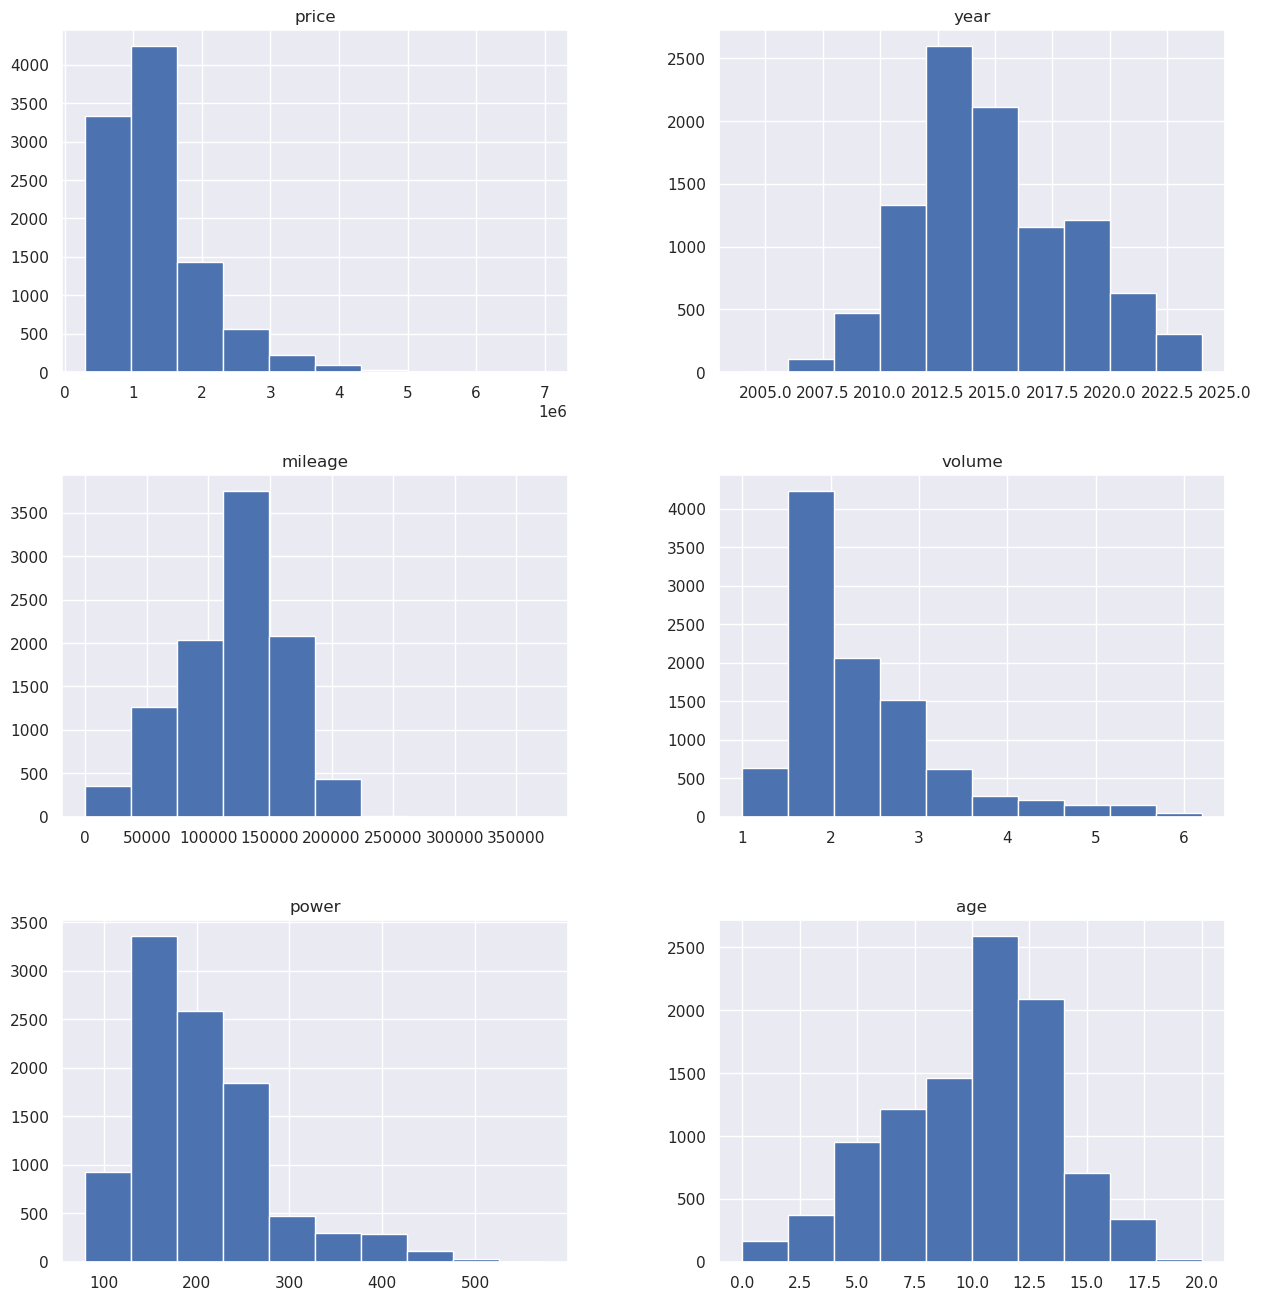

In [37]:
# Создадим гистограмму данных и посмотрим распределения данных
fig = plt.figure(figsize = (15,16))
ax = fig.gca()
carro.hist(ax = ax);

**Цена:** большинство автомобилей относительно недорогие, но есть и некоторые дорогие автомобили, которые встречаются реже.

**Год:** В наборе данных в значительной степени представлены автомобили, произведенные в начале-середине 2010-х годов.

**Пробег:** большинство автомобилей имеют умеренный пробег, а у небольшого количества автомобилей пробег может быть либо очень маленьким, либо очень большим.

**Объем:** Большинство автомобилей имеют относительно небольшой объем двигателя, и лишь немногие автомобили имеют большие двигатели.

**Мощность:** Большинство транспортных средств, представленных в данных, имеют выходную мощность менее 200 лошадиных сил.

**Возраст:** возраст автомобилей в наборе данных составляет от 10 до 15 лет.

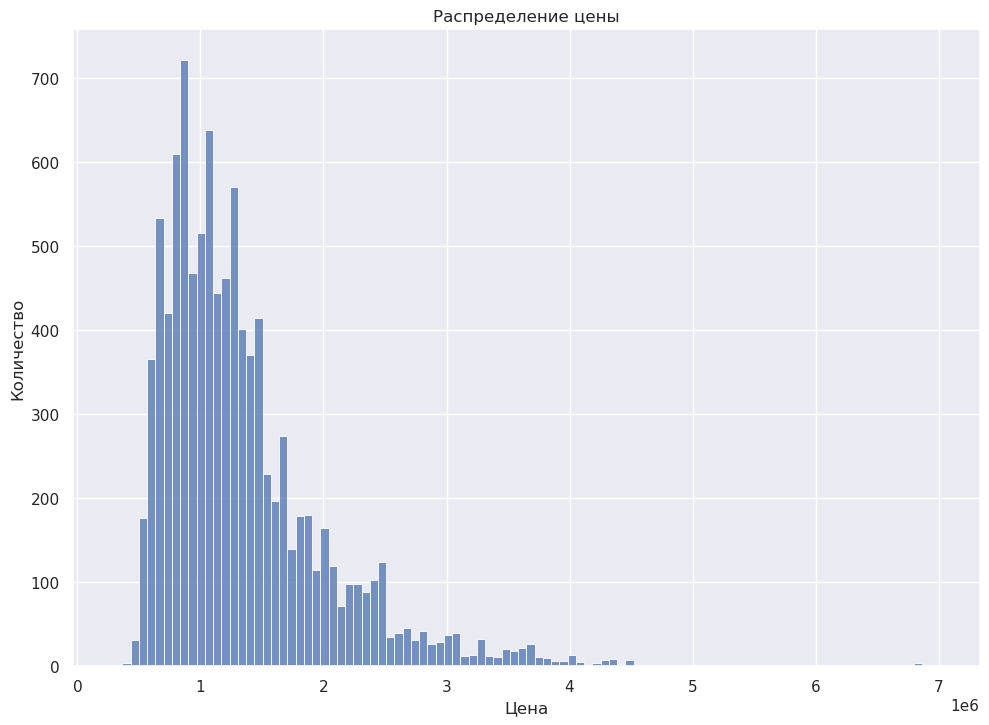

In [38]:
sns.histplot(carro['price'])
plt.xlabel('Цена')
plt.ylabel('Количество')
plt.title('Распределение цены')
plt.show()


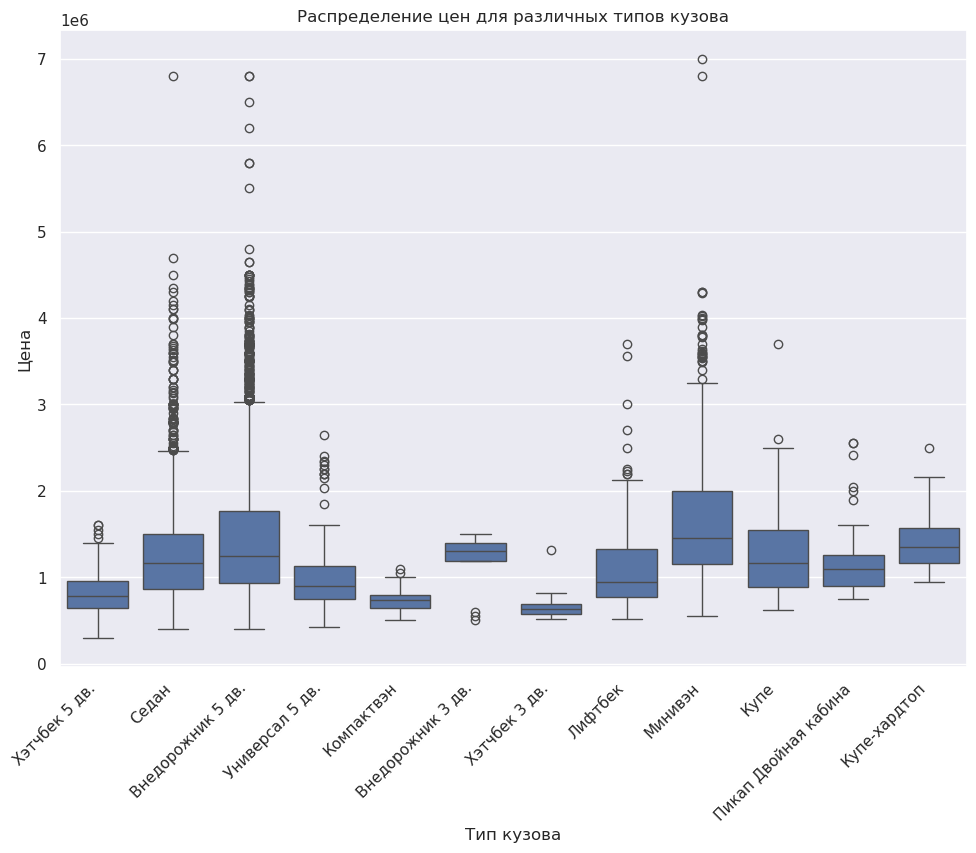

In [39]:
sns.boxplot(x='body_type', y='price', data=carro)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Тип кузова')
plt.ylabel('Цена')
plt.title('Распределение цен для различных типов кузова')
plt.show()

**Диапазон цен:** Существует широкий диапазон цен для разных типов телосложения. Некоторые типы имеют узкий диапазон цен, в то время как другие более изменчивы.

**Тенденции средних цен:** самые высокие средние цены у 5-дверных внедорожников и минивэнов. Хэтчбеки, компактные фургоны и 3-дверные внедорожники имеют более низкие средние цены. Седаны, универсалы, пикапы, купе и лифтбеки находятся посередине.

**Наличие аномальных моделей:** седаны, 5-дверные внедорожники и минивэны демонстрируют большее количество аномальных моделей высокого класса, что указывает на то, что автомобили премиум-класса в этих классах встречаются часто.

**Изменчивость цен:** некоторые типы кузова (например, седаны, 5-дверные внедорожники, минивэны) имеют широкий диапазон цен, в то время как другие более постоянны.

### Кореляция

In [40]:
corr = carro[['volume', 'mileage', 'price', 'year', 'power', 'age']].corr()

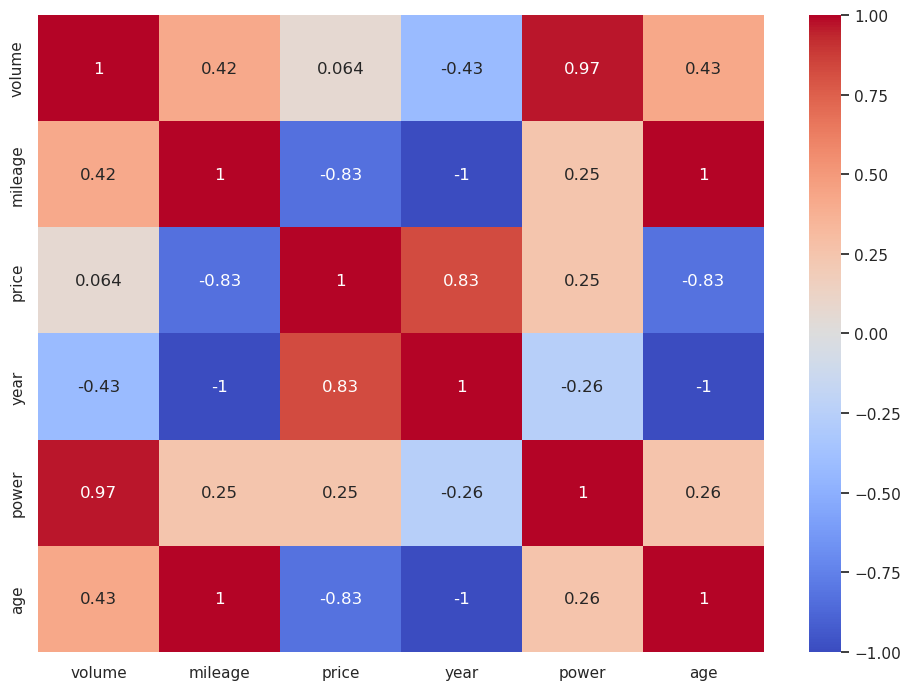

In [41]:
sns.heatmap(corr.corr(), annot=True, cmap='coolwarm')
plt.show()

##### Сильные положительные корреляции:

**Volume и Power:** Сильная положительная корреляция предполагает, что больший объем двигателя тесно связан с мощностью двигателя.

**Year и Price:** более новые автомобили, как правило, имеют значительно более высокие цены, что интуитивно понятно.

**Mileage и Age:** Это идеальная положительная связь, поскольку возраст автомобиля определяется по году выпуска, а пробег напрямую зависит от возраста автомобиля.

##### Сильные отрицательные корреляции:

**Mileage и Price:** больший пробег тесно связан с более низкими ценами, что отражает влияние эксплуатации на стоимость автомобиля.

**Mileage и Year:** У новых автомобилей пробег меньше.

**Age и Price:** Старые автомобили, как правило, имеют более низкую цену.

**Age и Year:** Это идеальная отрицательная связь, поскольку возраст автомобиля можно определить по году его выпуска.

##### Слабые корреляции:

**Volume и Price:** Очень слабая корреляция, что говорит о том, что объем не является основным фактором при определении цены.

**Power и Price:** Слабая положительная корреляция, предполагающая, что власть оказывает незначительное влияние на цену.

#### Анализ по марке и модели

In [42]:
average_price_by_model = carro.groupby('model')['price'].mean().sort_values(ascending=False)

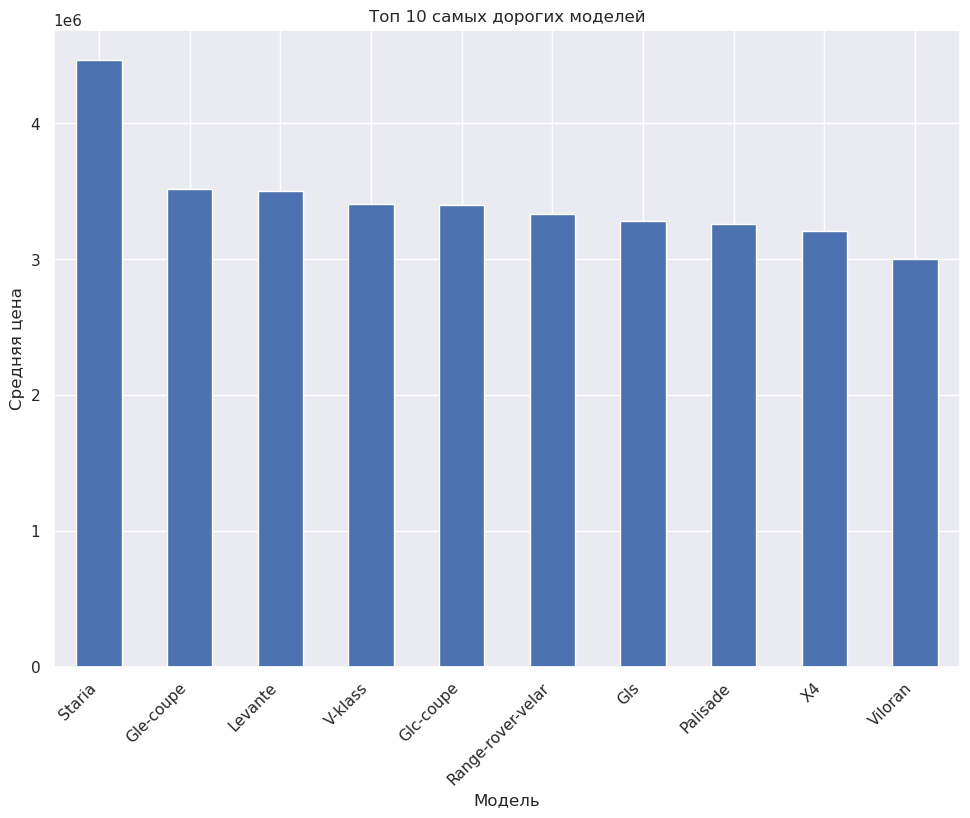

In [43]:
average_price_by_model.head(10).plot(kind='bar')
plt.title('Топ 10 самых дорогих моделей')
plt.ylabel('Средняя цена')
plt.xlabel('Модель')
plt.xticks(rotation=45, ha='right')
plt.show()

In [44]:
average_price_by_brand = carro.groupby('brand')['price'].mean().sort_values(ascending=False)

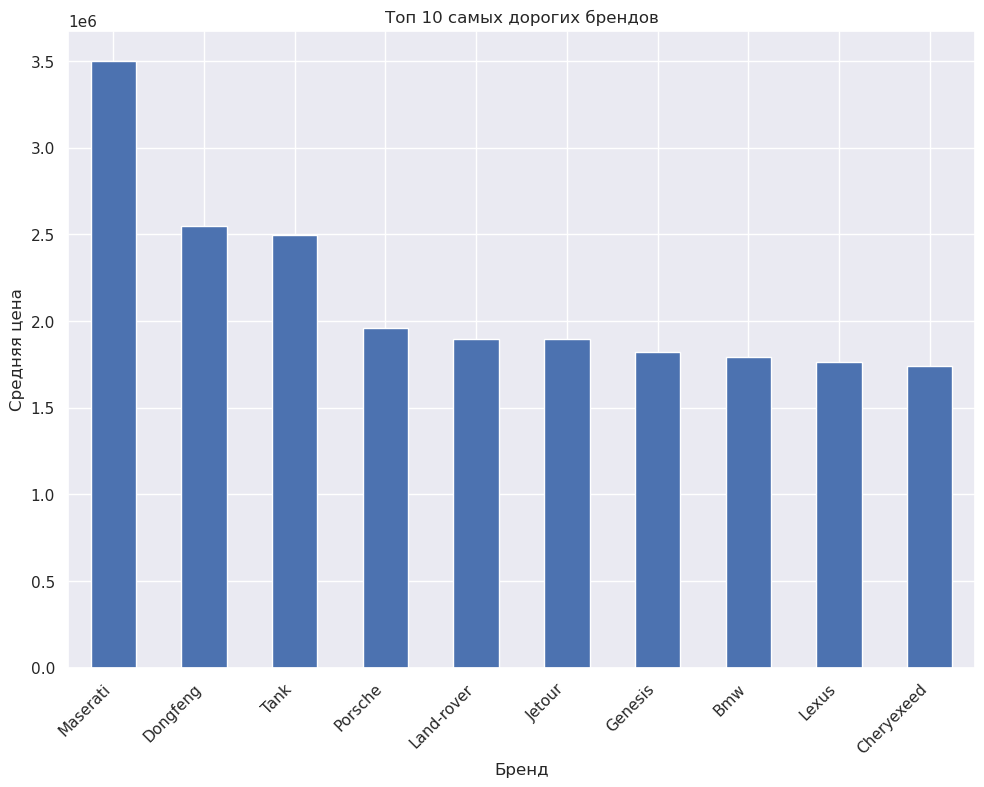

In [45]:
average_price_by_brand.head(10).plot(kind='bar')
plt.title('Топ 10 самых дорогих брендов')
plt.ylabel('Средняя цена')
plt.xlabel('Бренд')
plt.xticks(rotation=45, ha='right')
plt.show()

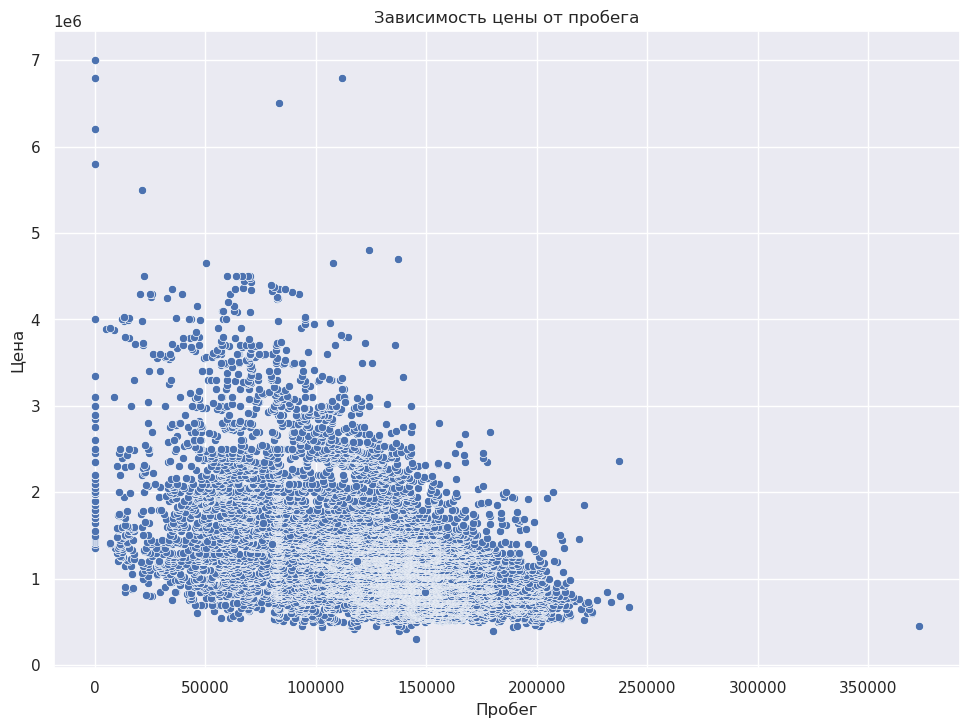

In [46]:
# Диаграмма рассеяния
sns.scatterplot(x='mileage', y='price', data=carro)
plt.title('Зависимость цены от пробега')
plt.ylabel('Цена')
plt.xlabel('Пробег')
plt.show()


**Снижение цены с пробегом:** по мере того, как автомобили становятся старше и на них больше ездят, их цены обычно снижаются. Эта зависимость нелинейна; первоначальное снижение становится гораздо более резким по мере того, как автомобиль начинает использоваться.

**Большой разброс цен при небольшом пробеге:** тот факт, что существуют автомобили с небольшим пробегом и высокой ценой, а также автомобили с низкой ценой, говорит о том, что важным фактором при определении цены являются и другие переменные, помимо пробега.

**Пробег как основной фактор:** По мере увеличения пробега диапазон цен сужается и снижается, что говорит о том, что пробег является важной переменной.

**Выбросы:** Наличие выбросов свидетельствует о том, что некоторые транспортные средства не соответствуют общей тенденции и поэтому требуют дополнительной проверки.

In [47]:
bins = [0, 100, 200, 1000]
labels = ['низкая', 'средняя', 'высокая']
carro['power'] = pd.cut(carro['power'], bins=bins, labels=labels, right=False)

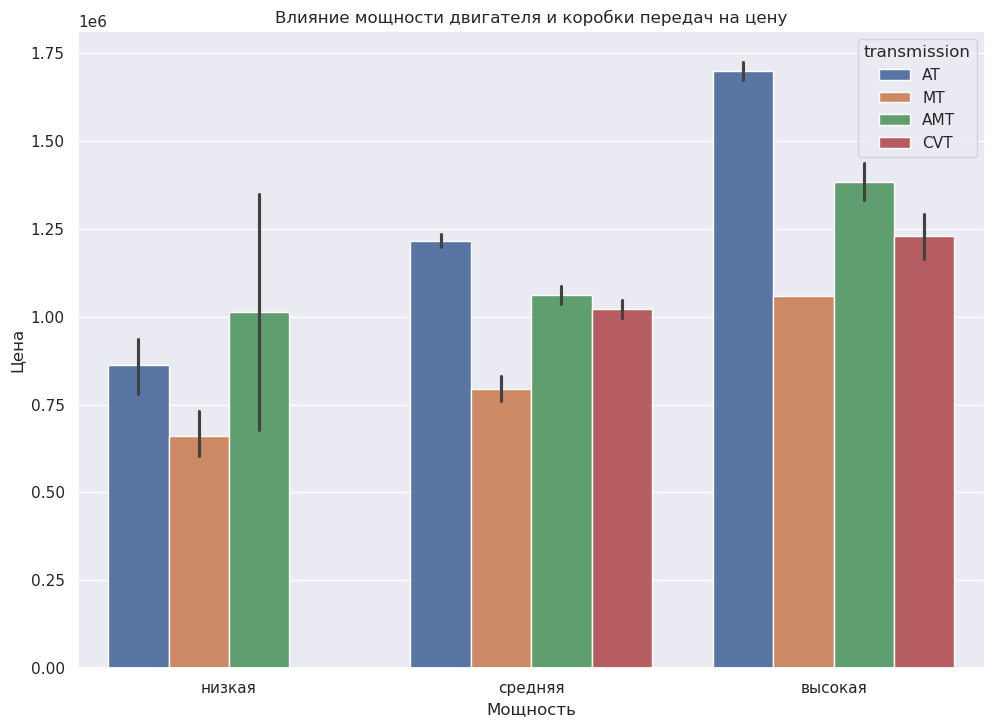

In [48]:
sns.barplot(data=carro, x='power', y='price', hue='transmission');
plt.title('Влияние мощности двигателя и коробки передач на цену');
plt.xlabel('Мощность');
plt.ylabel('Цена');

**Мощность и цена:** более высокая мощность двигателя, как правило, приводит к более высокой цене автомобиля.

**Трансмиссия и цена:** Автоматические коробки передач связаны с более высокой средней ценой автомобиля.

**Комбинированное влияние:** Мощность двигателя и тип трансмиссии взаимодействуют и существенно влияют на цену автомобиля. Автоматическая трансмиссия в сочетании с мощным двигателем ассоциируется с самыми высокими ценами.

In [49]:
name_count = carro.groupby('brand', as_index=False).agg({'price': 'count'}).sort_values('price', ascending=False)

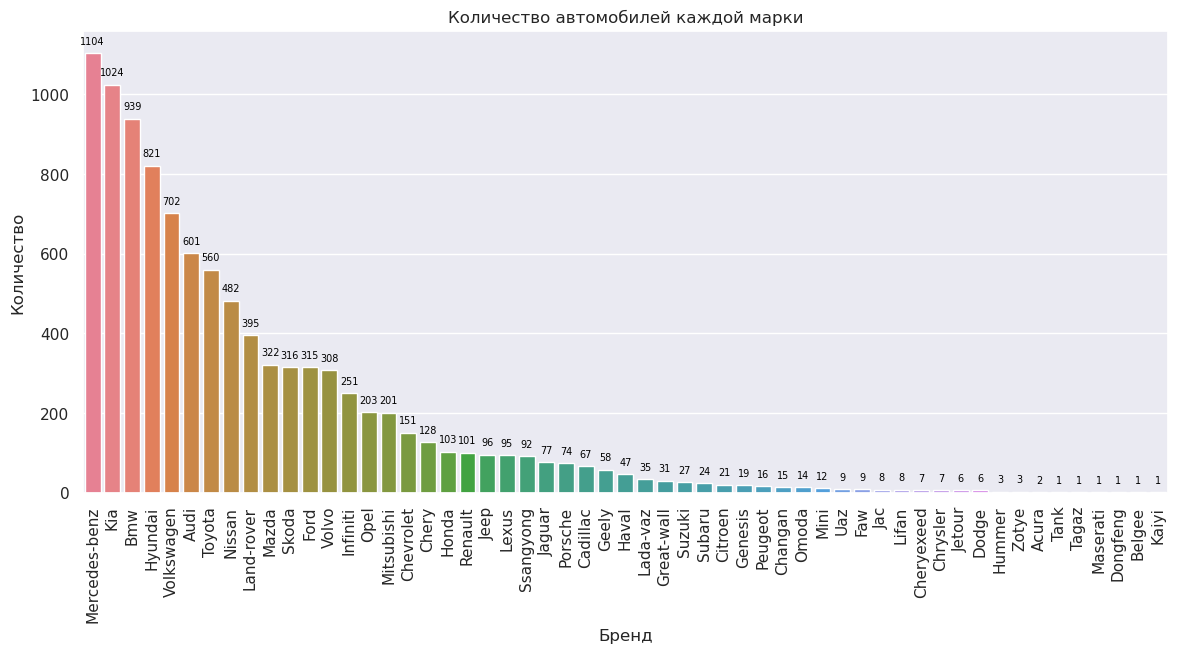

In [58]:
plt.figure(figsize=(14,6))
ax = sns.barplot(data = name_count, x = 'brand', y = 'price', hue = 'brand' )
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')
plt.ylabel('Количество')
plt.xlabel('Бренд')
plt.title('Количество автомобилей каждой марки')
plt.show()

- У ряда брендов в наборе данных очень мало записей — от 35 до 1. К таким брендам относятся Great Wall, Subaru, Citroe, Genesis, Peugeot и многие другие.

- Mercedes-Benz, Kia и BMW являются наиболее частыми брендами со значительным отрывом. Данные в значительной степени сконцентрированы на этих 3 брендах.

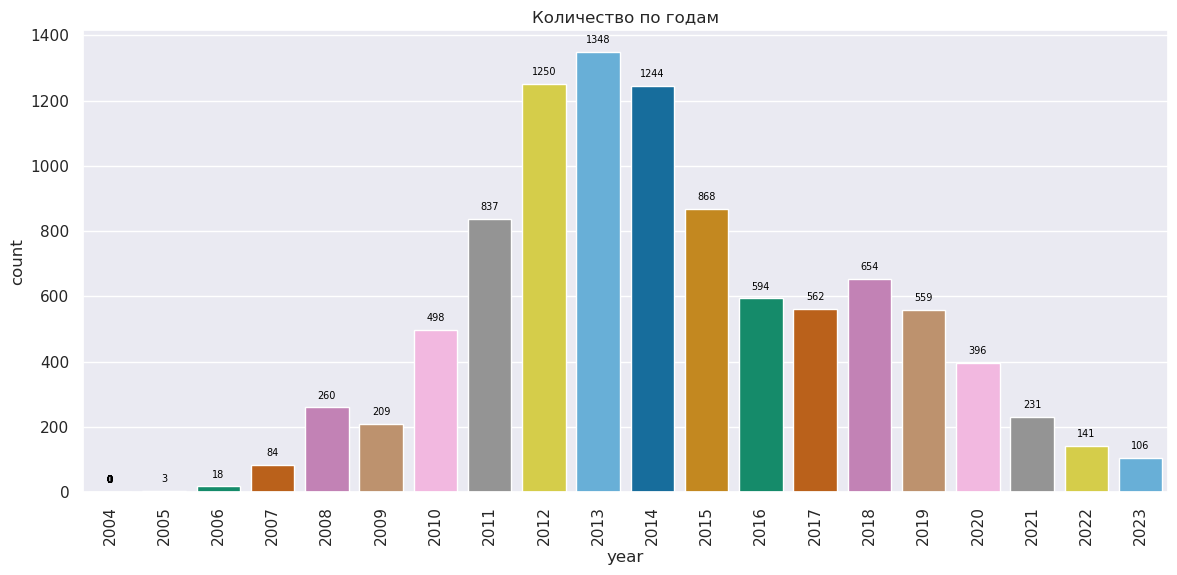

In [51]:
plt.figure(figsize=(14,6))
year_counts = carro['year'].value_counts()
year_sorted_df = year_counts.reset_index().sort_values(by ='year') # перейдем к dataframe и отсортируем
all_years = list(range(year_sorted_df['year'].min(), year_sorted_df['year'].max())) # создадим массив за полный год от min до max
df_full = pd.DataFrame({'year': all_years}) # создадим фрейм данных (полный столбец за год)
df_full = df_full.merge(year_sorted_df, on='year', how='left') # обьеденим 2 фрейма данных
df_full['Count'] = df_full['count'].fillna(0).astype(int) # заменим NaN на 0
df_full.drop(columns=['count']) # дропнем столбец с количеством
ax = sns.barplot(data = df_full, x = 'year', y = 'count', palette = 'colorblind', hue = 'year')
plt.xticks(rotation = 90)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom',
                fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')
plt.legend().set_visible(False) # отключим подписи
plt.title('Количество по годам')
plt.show()

На сайте carro.ru сконцентрированы автомобили начала-середины 2010-х годов (2011-2014 гг.), при этом наибольшее количество приходится на 2012-2014 гг.

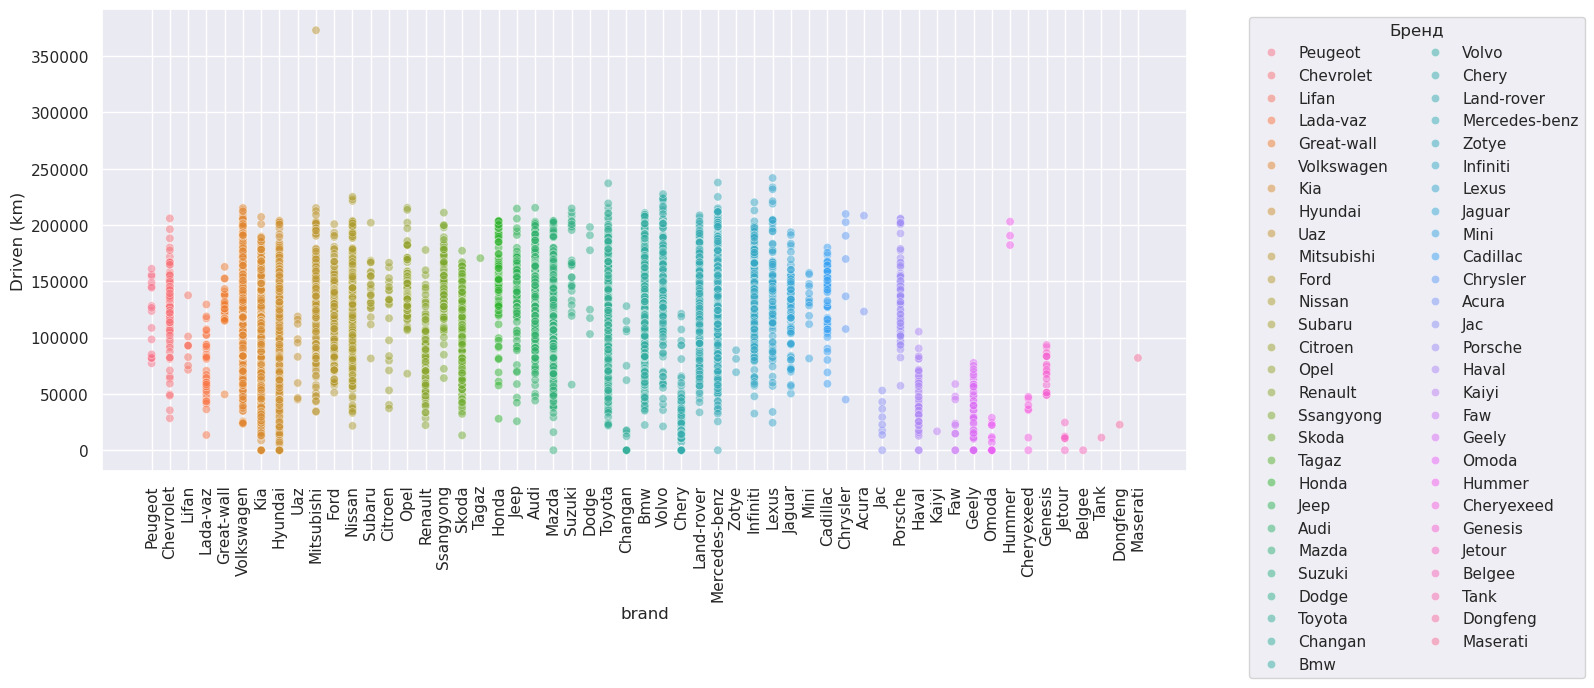

In [54]:
plt.figure(figsize=(14,6))
sns.scatterplot(data = carro,  x = 'brand', y = 'mileage', hue = 'brand', alpha = 0.5)
plt.legend(title="Бренд", bbox_to_anchor=(1.05, 1), loc='upper left',ncol = 2)
plt.xticks(rotation = 90)
plt.ylabel('Driven (km)')
plt.show()

**Постоянный диапазон пробега:** у большинства брендов автомобилей пробег автомобилей находится в среднем диапазоне.

**Перекрывающиеся пробеги:** диапазоны пробега значительно пересекаются у разных брендов, что говорит о том, что использование более изменчиво, чем бренд.

**Различия в зависимости от бренда:** между брендами есть тонкие различия, хотя большая часть диапазона пробега совпадает. Некоторые бренды, такие как Peugeot и Lada-vaz, похоже, склоняются к автомобилям с меньшим пробегом, а другие, такие как Kia и Hyundai, сосредоточены на среднем диапазоне пробега.

**Выбросы:** некоторые автомобили демонстрируют выбросы с чрезвычайно большим пробегом, что может быть полезно для дальнейшего исследования.

In [90]:
def calculate_confidence_interval(carro, confidence=0.90):
    """
    Рассчитывает доверительный интервал для среднего значения.

    Args:
        carro: pd.Series или np.array с данными.
        confidence: Уровень доверия (по умолчанию 0.90).

    Returns:
        tuple: (нижняя граница, верхняя граница) доверительного интервала.
    """
    mean = np.mean(carro)
    std = np.std(carro, ddof=1)  # Выборочное стандартное отклонение
    n = len(carro)
    # Использование t-распределения, когда стандартное отклонение генеральной совокупности неизвестно
    alpha = 1 - confidence
    t_critical = stats.t.ppf(1 - alpha / 2, n - 1)
    margin_of_error = t_critical * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return lower_bound, upper_bound

def bootstrap_confidence_interval(carro, n_iterations=1000, confidence=0.90):
    """
    Рассчитывает доверительный интервал для среднего значения, используя метод бутстрапа.

    Args:
        carro: pd.Series или np.array с данными.
        n_iterations: Количество бутстрап-итераций (по умолчанию 1000).
        confidence: Уровень доверия (по умолчанию 0.90).

    Returns:
        tuple: (нижняя граница, верхняя граница) доверительного интервала.
    """
    n = len(carro)
    bootstrap_means = []
    for _ in range(n_iterations):
        # Перевыборка с возвратом
        resampled_carro = np.random.choice(carro, size=n, replace=True)
        bootstrap_means.append(np.mean(resampled_carro))
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    lower_bound = np.percentile(bootstrap_means, lower_percentile)
    upper_bound = np.percentile(bootstrap_means, upper_percentile)
    return lower_bound, upper_bound

# Расчитаем доверительный интервал для средней цены всех автомобилей
lower_bound, upper_bound = calculate_confidence_interval(carro['price'])
print(f"90% CI для среднего значения цены (нормальное распределение): ({lower_bound:.2f}, {upper_bound:.2f})")

lower_bound_bootstrap, upper_bound_bootstrap = bootstrap_confidence_interval(carro['price'])
print(f"90% CI для среднего значения цены (бутстрап): ({lower_bound_bootstrap:.2f}, {upper_bound_bootstrap:.2f})")

# Расчет доверительного интервала для группы "Внедорожник 5 дв."
suv_prices = carro[carro['body_type'] == 'Внедорожник 5 дв.']['price']
lower_bound_suv, upper_bound_suv = calculate_confidence_interval(suv_prices)
print(f"90% CI для средней цены Внедорожник 5 дв. (нормальное распределение): ({lower_bound_suv:.2f}, {upper_bound_suv:.2f})")

lower_bound_suv_bootstrap, upper_bound_suv_bootstrap = bootstrap_confidence_interval(suv_prices)
print(f"90% CI для средней цены Внедорожник 5 дв. (бутстрап): ({lower_bound_suv_bootstrap:.2f}, {upper_bound_suv_bootstrap:.2f})")

90% CI для среднего значения цены (нормальное распределение): (1330650.11, 1353145.47)
90% CI для среднего значения цены (бутстрап): (1330315.20, 1353600.81)
90% CI для средней цены Внедорожник 5 дв. (нормальное распределение): (1435872.42, 1470076.89)
90% CI для средней цены Внедорожник 5 дв. (бутстрап): (1435996.01, 1470971.66)


**Средняя цена автомобилей:** Средняя цена автомобилей составляет около 1,34 миллиона.

**Внедорожники:** Автомобили типа «Внедорожник 5 дв.» имеют более высокую цену (около 1,45–1,47 миллиона), чем среднюю цену по всем автомобилям.

**Статистическая значимость:** Мы можем с 90% уверенностью сказать, что разница между средней ценой «Внедорожник 5 дв.» и средней ценой на все автомобили не случайна, и что внедорожники, в среднем, стоят выше.

# Вывод

### Основные выводы

**Распределение цен:**

Рынок в значительной степени перекошен в сторону недорогих автомобилей, при этом наблюдается длинный «хвост» из более дорогих автомобилей.
Это говорит о том, что, хотя роскошные и высокопроизводительные автомобили существуют, они относительно менее распространены, чем более доступные варианты.

**Год и возраст:**

Данные сосредоточены на транспортных средствах, произведенных в начале-середине 2010-х годов, с пиковым показателем около 2012–2014 годов.
Распределение по возрасту показывает, что большинству автомобилей около 10–15 лет.
Заметно снижение количества транспортных средств более поздних лет, что указывает на уменьшение данных по более новым транспортным средствам.

**Пробег:**

Большинство автомобилей имеют умеренный пробег, достигающий 100 000 км и более.
Меньше автомобилей с очень маленьким или очень большим пробегом.
Характеристики двигателя

Большинство автомобилей используют бензиновые двигатели.
Дизельные двигатели являются вторыми по распространенности.
Гибридные двигатели встречаются довольно редко.
Объем двигателей в основном составляет 1,5 и 2,0 литра, при этом автомобили с двигателями большего размера встречаются реже.
Большинство транспортных средств имеют мощность двигателя менее 200 лошадиных сил.

**Типы кузова:**

Доминирующим типом кузова является 5-дверный внедорожник, за ним следуют седаны.
Существует множество других типов кузова, но они встречаются реже, что подчеркивает особое предпочтение рынка внедорожников.

**Коробка передач:**

Автоматические коробки передач (АТ) являются наиболее распространенным типом с большим отрывом, что говорит о предпочтительности этого типа.
Механические коробки передач (МТ) встречаются реже всего.

**Владельцы:**

Большинство транспортных средств принадлежали одному или двум предыдущим владельцам.
Новых автомобилей немного, а те, у которых много владельцев, встречаются довольно редко.

### Важно учитывать ограничения:

**Смещение данных:** сайт carro.ru, по-видимому, отдает предпочтение определенным маркам и возрастам транспортных средств.
**Географическая предвзятость:** данные отражают только Московский регион, что влияет на интерпретацию общего рынка.
**Метод сбора данных:** Данные были собраны за Декабрь 2024 года.

### Заключение

Представленный набор данных рисует картину автомобильного рынка с концентрацией автомобилей среднего класса и среднего возраста, с сильным предпочтением внедорожников, автоматических коробок передач и бензиновых двигателей. Наличие нескольких доминирующих брендов и многих менее частых говорит о том, что эти данные предвзяты и не представляют весь автомобильный рынок. Анализ этого набора данных дает ценную информацию, но его следует интерпретировать с учетом присущих ему предвзятостей.